In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("./Data/frinksMovementSurvery.csv")

In [2]:
df.head()

,Timestamp,Weighted Pullup 1RM (% of BW),Max Front Lever progression (3 seconds good form),Other thoughts or comments? Helpful data,Bodyweight (kg),Max pullups (endurance),Height (cm)
0,10/7/2020 0:41:37,<10% (so usually couple of pullups with BW),Straddle lever,NaN,59.8,20.0,1.65
1,10/6/2020 20:38:42,65%-80%,Full lever,NaN,72.0,21.0,1.78
2,10/7/2020 1:41:25,50%-65%,Straddle Halflay lever,I have 50% weighted pull up and barely 3 secon...,68.0,17.0,69
3,10/6/2020 19:50:48,50%-65%,Straddle lever,NaN,62.0,20.0,142
4,10/6/2020 20:10:42,30%-50%,Full lever,NaN,45.0,20.0,160


In [3]:
df.columns = ['time', 'pullup', 'FLprogression', 'comments', 'weight', 'Npullups', 'height']
df = df.dropna(subset=['pullup', 'FLprogression', 'weight', 'Npullups', 'height'])

In [4]:
df.head()

,time,pullup,FLprogression,comments,weight,Npullups,height
0,10/7/2020 0:41:37,<10% (so usually couple of pullups with BW),Straddle lever,NaN,59.8,20.0,1.65
1,10/6/2020 20:38:42,65%-80%,Full lever,NaN,72.0,21.0,1.78
2,10/7/2020 1:41:25,50%-65%,Straddle Halflay lever,I have 50% weighted pull up and barely 3 secon...,68.0,17.0,69
3,10/6/2020 19:50:48,50%-65%,Straddle lever,NaN,62.0,20.0,142
4,10/6/2020 20:10:42,30%-50%,Full lever,NaN,45.0,20.0,160


In [5]:
def heightToCM(h_str):
    ret_val = 0.0
    h_str = str(h_str)
    index1 = h_str.find('’')
    index2 = h_str.find('\'')
    index = max(index1, index2)
    if(index > -1):
        feet = int(h_str[0:index])
        inches = int(h_str[index+1:])
        
        ret_val = float(feet*12 + inches) *2.54
    else:
        ret_val = float(h_str.replace(',', '').replace('.', '').replace('m', '').replace('c','').replace(',',''))
    if(ret_val < 2.3):
        ret_val *= 100
    if(ret_val < 90):
        ret_val *= 2.54
    return ret_val
            
df.height  = df.height.apply(heightToCM)

In [6]:
def setWeightsToNan(x):
    if (x<0):
        return np.nan 
    elif (x>200):
        return np.nan 
    return x

df.weight
df.weight = df.weight.apply(setWeightsToNan)

In [12]:
df_noComment = df.drop(columns=["comments","time"])
df.to_csv("./Data/cleanedData.csv")
df_noComment.to_csv("./Data/cleanedDataNoComment.csv")
df_noComment.head()


,pullup,FLprogression,weight,Npullups,height
0,<10% (so usually couple of pullups with BW),Straddle lever,59.8,20.0,165.00
1,65%-80%,Full lever,72.0,21.0,178.00
2,50%-65%,Straddle Halflay lever,68.0,17.0,175.26
3,50%-65%,Straddle lever,62.0,20.0,142.00
4,30%-50%,Full lever,45.0,20.0,160.00


In [7]:
from sklearn.preprocessing import OrdinalEncoder

progressionEnc = OrdinalEncoder()
MaxPullUpEnc = OrdinalEncoder()

FLProgressionTr = progressionEnc.fit_transform(df.FLprogression.values.reshape(-1,1))
MaxPullupTr = MaxPullUpEnc.fit_transform(df.pullup.values.reshape(-1,1))

print(len(FLProgressionTr))
print(len(MaxPullupTr))

204
204


In [59]:
from sklearn.preprocessing import StandardScaler


Y = FLProgressionTr.astype(np.int16).ravel()
X = np.concatenate((MaxPullupTr, 
                    df.height.values.reshape(-1,1),
                    df.weight.values.reshape(-1,1),
                    df.Npullups.values.reshape(-1,1)
                   ),axis=1)

Xscaler = StandardScaler()
X_scaled = Xscaler.fit_transform(X)

X_feature = ['Max Pull up', 'Height', 'Weight', 'N Pull Ups']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.10, random_state=42)


def barPlotImportance(importance):
    plt.bar([X_feature[x] for x in range(len(importance))], importance)
    plt.show()

def printScore(score):
    print('Score: %.3f' % score)
    
def fitModelAndMakePlots(model):
    model.fit(X_train, y_train)

    printScore(model.score(X_test, y_test))
    barPlotImportance(model.feature_importances_)

def interpretImportance(results):
    importance = results.importances_mean
    barPlotImportance(model.feature_importances_)

Score: 0.42857


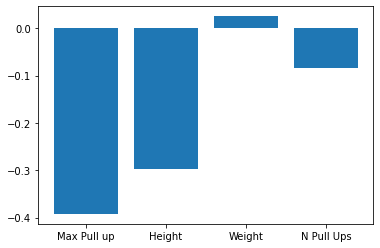

In [51]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, multi_class='multinomial', solver='lbfgs').fit(X_train, y_train)
printScore(clf.score(X_test, y_test))


barPlotImportance(clf.coef_[0])

### Linear Regression

Score: -0.04722


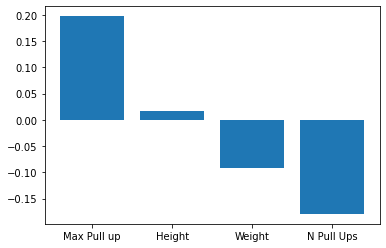

In [53]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.coef_
# summarize feature importance
printScore(model.score(X_test, y_test))
barPlotImportance(importance)

### Decision Tree

-1.3408723747980615
Score: -1.34087


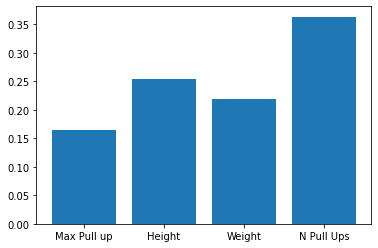

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


model = DecisionTreeRegressor()
model.fit(X_train, y_train)

printScore(model.score(X_test, y_test))
barPlotImportance(model.feature_importances_)

### Decision Tree Classifier

Score: 0.333


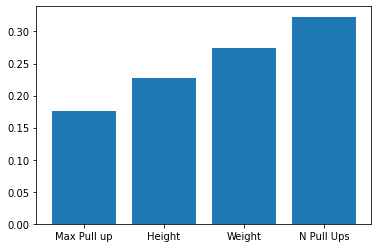

In [57]:
from sklearn.tree import DecisionTreeClassifier

fitModelAndMakePlots(DecisionTreeClassifier())

### Random Forest Ensemble

Score: -0.00652


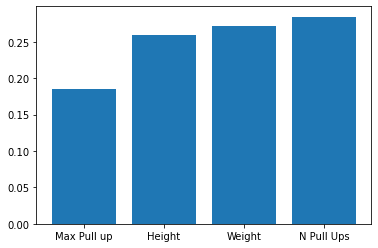

In [54]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

printScore(model.score(X_test, y_test))
barPlotImportance(model.feature_importances_)

### Random Forest Classifier

Score: 0.476


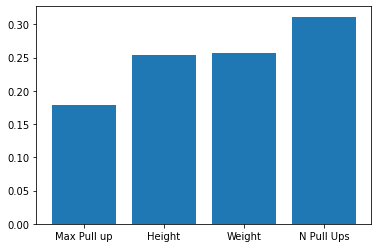

In [56]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
fitModelAndMakePlots(model)

## Feature Importance using Lasso

Best alpha using built-in LassoCV: 41.376622
Best score using built-in LassoCV: 0.000000
Lasso picked 0 variables and eliminated the other 4 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

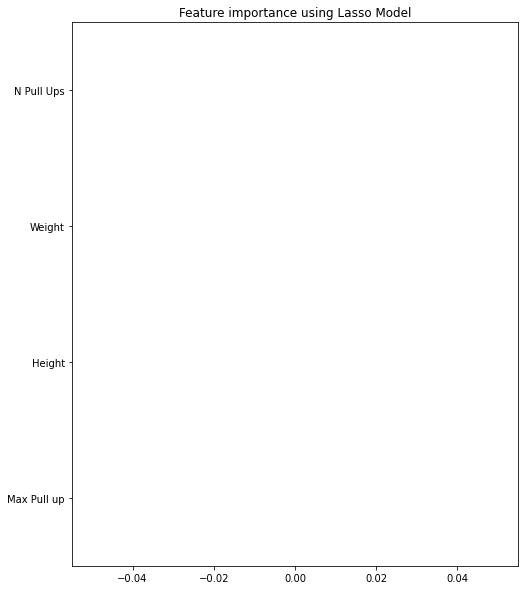

In [74]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import matplotlib
import statsmodels.api as sm
%matplotlib inline
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso#Loading the dataset

reg = LassoCV()
reg.fit(X_scaled, Y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_scaled,Y))
coef = pd.Series(reg.coef_, index = X_feature)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### Neural Network

In [79]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(max_iter=1000, solver='sgd')
model.fit(X_train, y_train)

printScore(model.score(X_test, y_test))

Score: 0.476
